# Washington DC Biking data | Hourly Bike Count Prediction
MBD O-1-5

### Notebook preperation

In [130]:
# Imports
%matplotlib inline


from My_Functions import * 
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from collections import defaultdict

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score,roc_curve
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict,validation_curve
from sklearn.ensemble import RandomForestRegressor
import datetime

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelBinarizer, RobustScaler,PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from scipy import stats
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator , MultipleLocator
from gplearn.genetic import SymbolicRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer,MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression,LinearRegression, OrthogonalMatchingPursuit
from sklearn.model_selection import train_test_split , TimeSeriesSplit, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from matplotlib.gridspec import GridSpec
import plotly.tools as tls
import plotly
plotly.tools.set_credentials_file(username='Furqan92', api_key='22DfVN5rFRg79OYygN5h')
import plotly.plotly as py
from sklearn.decomposition import PCA
from pandas import DataFrame 
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.simplefilter(action='ignore')
random_seed = 1234

In [131]:
# To automatically reload the function file 
%load_ext autoreload
%aimport My_Functions
%run My_Functions.py
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Exploration

In [132]:
# Data Import
daily_raw_data = pd.read_csv('day.csv')
hourly_raw_data=pd.read_csv('hour.csv')

In [133]:
hourly_raw_data.tail()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61
17378,17379,2012-12-31,1,1,12,23,0,1,1,1,0.26,0.2727,0.65,0.1343,12,37,49


In [134]:
daily_raw_data.isnull().any()

instant       False
dteday        False
season        False
yr            False
mnth          False
holiday       False
weekday       False
workingday    False
weathersit    False
temp          False
atemp         False
hum           False
windspeed     False
casual        False
registered    False
cnt           False
dtype: bool

In [135]:
daily_raw_data.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

### DAILY DATA visuals

In [136]:
# Making a copy of daily data for graphs
graph_data_daily=daily_raw_data.copy()
graph_data_daily["dteday"]=graph_data_daily["dteday"].map(lambda x:  pd.to_datetime(x))

In [137]:
mpl_fig = plt.figure()
ax= plt.axes()
ax.plot(graph_data_daily['dteday'],graph_data_daily['cnt'])
ax.plot(graph_data_daily['dteday'],graph_data_daily['registered'])
ax.plot(graph_data_daily['dteday'],graph_data_daily['casual'])
#ax.legend(['cnt', 'registered', 'casual'], loc='upper left')
#ax.figure(figsize=(20,10))
# locator=MaxNLocator(prune='both',nbins=8)
# ax.xaxis.set_major_locator(locator)


plotly_fig=tls.mpl_to_plotly(mpl_fig)
plotly_fig['layout']['xaxis'] = {
   'tickmode': 'auto',
   'nticks': 10
    }
plotly_fig['layout']['showlegend'] = True
plotly_fig['layout'] = {'width':800}
plotly_fig['layout']['title'] = 'Daily Bike Users'
py.iplot(plotly_fig,filename='Daily_Bike_Users')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~Furqan92/0 or inside your plot.ly account where it is named 'Daily_Bike_Users'


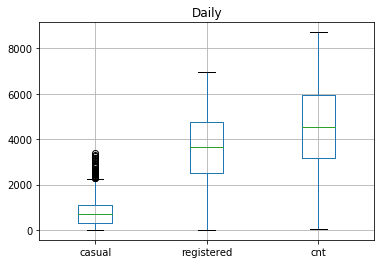

In [138]:
graph_data_daily.boxplot(column = ['casual','registered','cnt'])
plt.title('Daily')
plt.show()

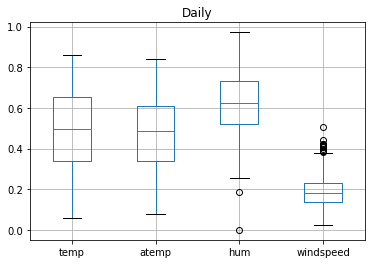

In [139]:
graph_data_daily.boxplot(column = ['temp','atemp','hum','windspeed'])
plt.title('Daily')
plt.show()

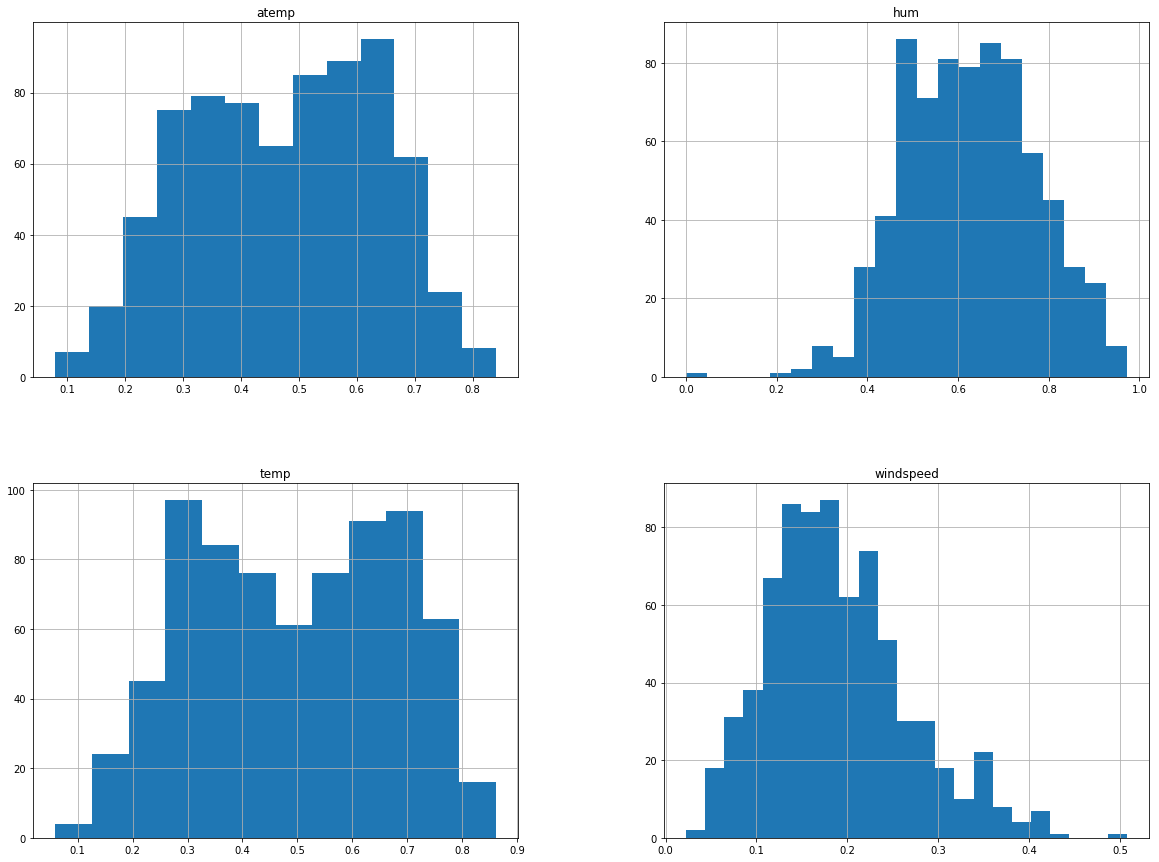

<Figure size 432x288 with 0 Axes>

In [12]:
num_bins = 'auto'
to_hist = ['atemp','temp','hum','windspeed']
graph_data_daily[to_hist].hist(bins=num_bins, figsize=(20, 15))

plt.show()
plt.savefig('myfig')

Text(0.5, 1.0, 'Humidity per Day')

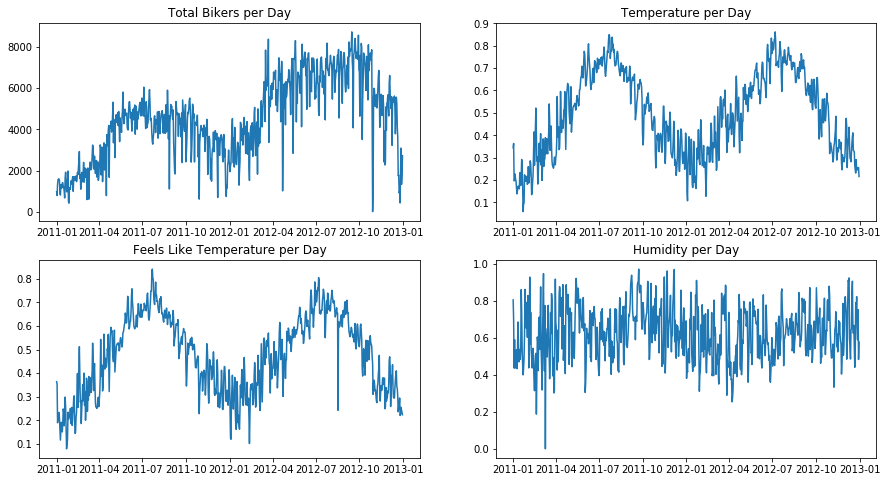

In [13]:
fig=plt.figure(figsize=(15,8))
plt.subplot(2,2, 1)
plt.plot(graph_data_daily['dteday'],graph_data_daily['cnt'])
plt.title('Total Bikers per Day')
plt.subplot(2, 2, 2)
plt.plot(graph_data_daily['dteday'],graph_data_daily['temp'])
plt.title('Temperature per Day')
plt.subplot(2, 2, 3)
plt.plot(graph_data_daily['dteday'],graph_data_daily['atemp'])
plt.title('Feels Like Temperature per Day')
plt.subplot(2, 2, 4)
plt.plot(graph_data_daily['dteday'],graph_data_daily['hum'])
plt.title('Humidity per Day')


In [14]:
# # sns.lineplot(x="dteday", y="cnt", hue="casual", data=hourly_raw_data[:100])
# df = daily_raw_data[:30].copy()
# df.set_index(df.dteday)
# # sns.tsplot(df.cnt)
# plt.plot( 'dteday', 'cnt', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
# plt.plot( 'dteday', 'casual', data=df, marker='', color='maroon', linewidth=2)
# plt.plot( 'dteday', 'registered', data=df, marker='', color='olive', linewidth=2, linestyle='dashed')
# plt.legend()
# plt.show()

### HOURLY DATA visuals

In [141]:
# Making a copy of hourly data for graphs
graph_data_hourly=hourly_raw_data.copy()
graph_data_hourly["dteday"]=graph_data_hourly["dteday"].map(lambda x:  pd.to_datetime(x))

In [16]:
mpl_fig = plt.figure()
ax= plt.axes()
ax.plot(graph_data_hourly['dteday'],graph_data_hourly['cnt'])
ax.plot(graph_data_hourly['dteday'],graph_data_hourly['registered'])
ax.plot(graph_data_hourly['dteday'],graph_data_hourly['casual'])
#ax.legend(['cnt', 'registered', 'casual'], loc='upper left')
#ax.figure(figsize=(20,10))
# locator=MaxNLocator(prune='both',nbins=8)
# ax.xaxis.set_major_locator(locator)


plotly_fig=tls.mpl_to_plotly(mpl_fig)
plotly_fig['layout']['xaxis'] = {
   'tickmode': 'auto',
   'nticks': 10
    }
plotly_fig['layout']['showlegend'] = True
plotly_fig['layout'] = {'width':800}
plotly_fig['layout']['title'] = 'Hourly Bike Users'
py.iplot(plotly_fig,filename='Hourly_Bike_Users')

The draw time for this plot will be slow for clients without much RAM.


In [17]:

# import matplotlib.dates as mdates

# # Set the locator
# locator = mdates.MonthLocator()  # every month
# # Specify the format - %b gives us Jan, Feb...
# fmt = mdates.DateFormatter('%b')

# plt.figure(figsize=(20,10))
# plt.plot(graph_data_hourly['dteday'],graph_data_hourly['cnt'])
# plt.plot(graph_data_hourly['dteday'],graph_data_hourly['registered'])
# plt.plot(graph_data_hourly['dteday'],graph_data_hourly['casual'])
# plt.legend(['cnt', 'registered', 'casual'], loc='upper left')

# X = plt.gca().xaxis
# X.set_major_locator(locator)
# # Specify formatter
# X.set_major_formatter(fmt)

# plt.show()

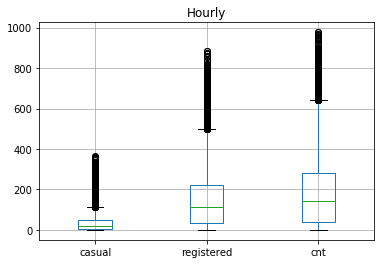

In [18]:
graph_data_hourly.boxplot(column = ['casual','registered','cnt'])
plt.title('Hourly')
plt.show()

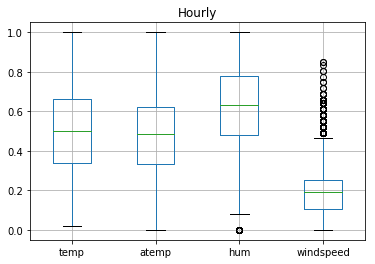

In [19]:
graph_data_hourly.boxplot(column = ['temp','atemp','hum','windspeed'])
plt.title('Hourly')
plt.show()

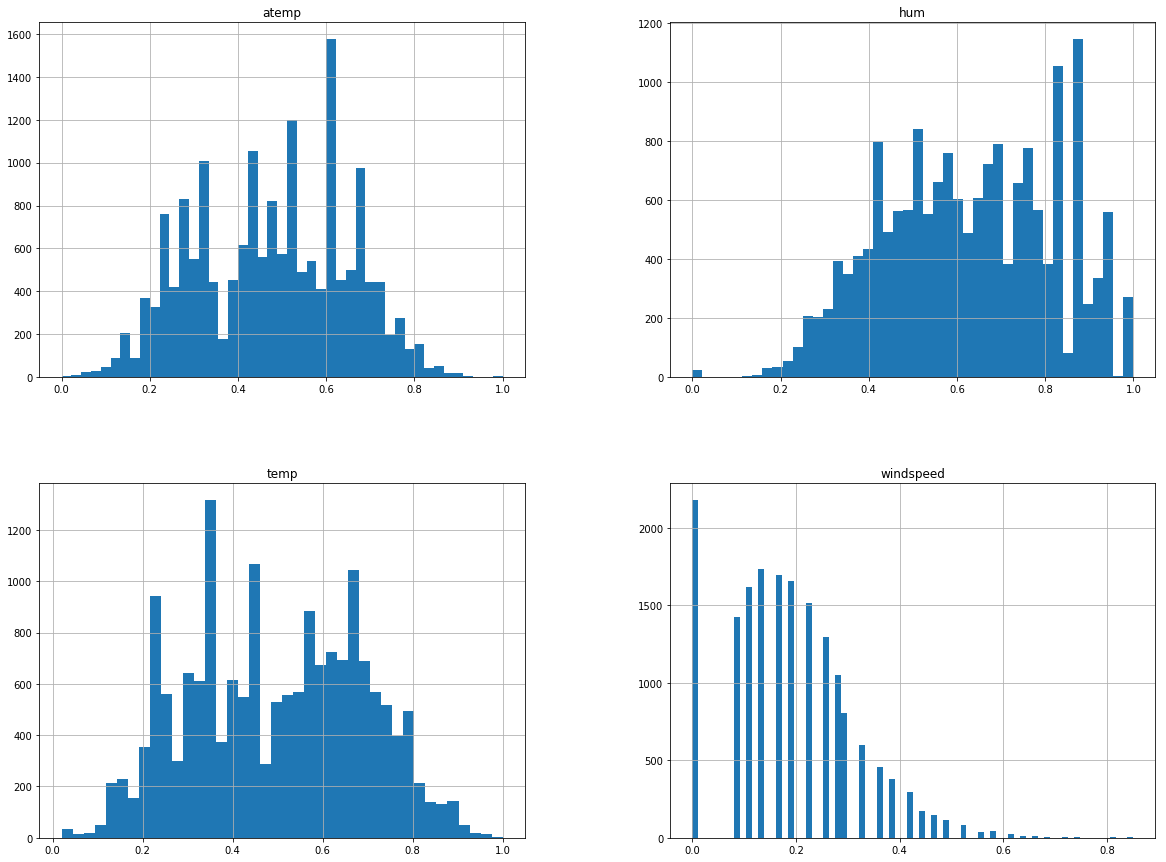

In [20]:
num_bins = 'auto'
to_hist = ['atemp','temp','hum','windspeed']
graph_data_hourly[to_hist].hist(bins=num_bins, figsize=(20, 15))

plt.show()

Text(0.5, 1.0, 'Humidity per Hour')

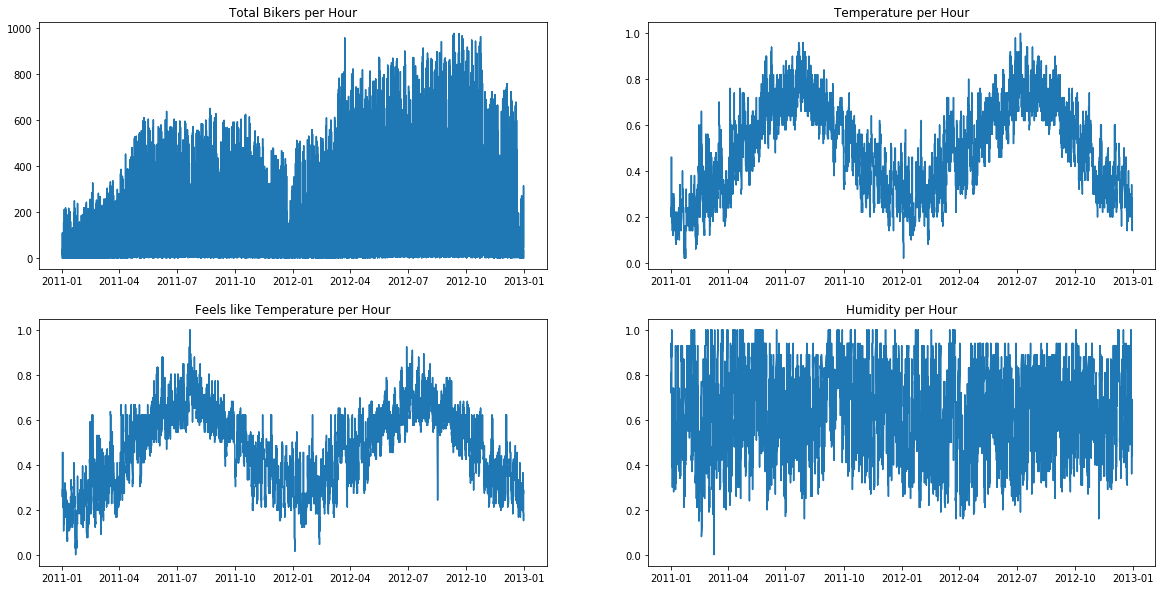

In [21]:
plt.figure(figsize=(20,10))
plt.subplot(2,2, 1)
plt.plot(graph_data_hourly['dteday'],graph_data_hourly['cnt'])
plt.title('Total Bikers per Hour')
plt.subplot(2, 2, 2)
plt.plot(graph_data_hourly['dteday'],graph_data_hourly['temp'])
plt.title('Temperature per Hour')
plt.subplot(2, 2, 3)
plt.plot(graph_data_hourly['dteday'],graph_data_hourly['atemp'])
plt.title('Feels like Temperature per Hour')
plt.subplot(2, 2, 4)
plt.plot(graph_data_hourly['dteday'],graph_data_hourly['hum'])
plt.title('Humidity per Hour')

In [22]:
graph_data_hourly.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


[Text(0.5, 1.0, 'Weekday wise hourly distribution of Total Bikers')]

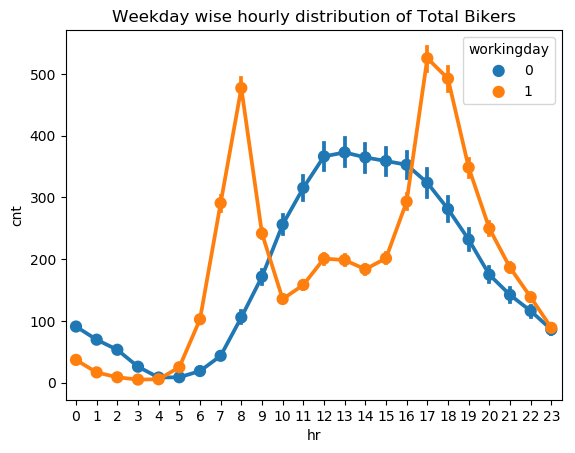

In [218]:
# Option 1 for weekend/weekday graph
fig,ax = plt.subplots()
sns.pointplot(data=graph_data_hourly[['hr',
                           'cnt',
                           'workingday']],
              x='hr',
              y='cnt',
              hue='workingday',
              ax=ax)
ax.set(title="Weekday wise hourly distribution of Total Bikers")

[Text(0.5, 1.0, 'Weekday wise hourly distribution of Total Bikers')]

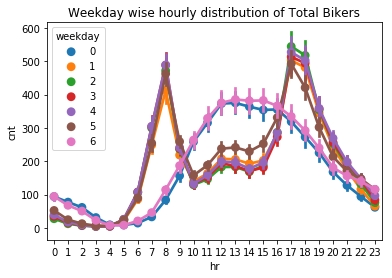

In [147]:
# Option 1 for weekend/weekday graph
fig,ax = plt.subplots()
sns.pointplot(data=graph_data_hourly[['hr',
                           'cnt',
                           'weekday']],
              x='hr',
              y='cnt',
              hue='weekday',
              ax=ax)
ax.set(title="Weekday wise hourly distribution of Total Bikers")

In [24]:
# option 2 for weekend/weekday graphs
g = sns.lmplot(x="hr", y="cnt", hue="weekday", col="weekday",
...                data=graph_data_hourly, height=6, aspect=.4, x_jitter=.1)

SyntaxError: invalid syntax (<ipython-input-24-f6b4658df69a>, line 3)

### EDA after spliting

In [ ]:
wd_hr.boxplot(column = ['casual','registered','cnt'])
plt.title('Casual, Registered, and Total Bikers on Weekdays')
plt.show()
we_hr.boxplot(column = ['casual','registered','cnt'])
plt.title('Casual, Registered, and Total Bikers on Weekends')
plt.show()

In [ ]:
wd_hr.boxplot(column = ['temp','atemp','hum','windspeed'])
plt.title('Temperature, Feels like Temperate, Humidity, and Windspeed on Weekdays')
plt.show()
we_hr.boxplot(column = ['temp','atemp','hum','windspeed'])
plt.title('Temperature, Feels like Temperate, Humidity, and Windspeed on Weekends')
plt.show()

In [ ]:
num_bins = 'auto'
to_hist = ['atemp','temp','hum','windspeed']
wd_hr[to_hist].hist(bins=num_bins, figsize=(20, 15))

plt.show()

In [ ]:
num_bins = 'auto'
to_hist = ['atemp','temp','hum','windspeed']
we_hr[to_hist].hist(bins=num_bins, figsize=(20, 15))

plt.show()

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(2,2, 1)
plt.plot(wd_hr['dteday'],wd_hr['cnt'])
plt.title('Total Bikers on Weekday')
plt.subplot(2, 2, 2)
plt.plot(wd_hr['dteday'],wd_hr['relative_temp'])
plt.title('Temperature on Weekday')
plt.subplot(2, 2, 3)
plt.plot(wd_hr['dteday'],wd_hr['atemp'])
plt.title('Feels Like Temperature on Weekday')
plt.subplot(2, 2, 4)
plt.plot(wd_hr['dteday'],wd_hr['hum'])
plt.title('Humidity on Weekday')

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(2,2, 1)
plt.plot(we_hr['dteday'],we_hr['cnt'])
plt.title('Total Bikers on Weekend')
plt.subplot(2, 2, 2)
plt.plot(we_hr['dteday'],we_hr['temp'])
plt.title('Temperature on Weekend')
plt.subplot(2, 2, 3)
plt.plot(we_hr['dteday'],we_hr['atemp'])
plt.title('Feels Like Temperature on Weekend')
plt.subplot(2, 2, 4)
plt.plot(we_hr['dteday'],we_hr['hum'])
plt.title('Humidity on Weekend')

In [ ]:
fig,ax = plt.subplots(1,2,sharey=True,sharex=True,figsize=(15,5))
#plt.figure(figsize=(1000,1000))
sns.pointplot(data=we_hr[['hr',
                           'cnt',
                           'season']],
              x='hr',
              y='cnt',
              hue='season',
              ax=ax[0])
sns.pointplot(data=wd_hr[['hr',
                           'cnt',
                           'season']],
              x='hr',
              y='cnt',
              hue='season',
              ax=ax[1])
ax[0].set(title="Weekends")
ax[1].set(title="Weekdays")
plt.show()
fig.savefig('test2')

In [214]:
hey = hourly_raw_data.corr()['cnt'][:]
hey.sort_values()

hum          -0.322911
weathersit   -0.142426
holiday      -0.030927
weekday       0.026900
workingday    0.030284
windspeed     0.093234
mnth          0.120638
season        0.178056
yr            0.250495
instant       0.278379
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

### Prediction Graphs

In [49]:
full_wd=pd.read_csv('full_wd.csv')
full_we=pd.read_csv('full_we.csv')
#full_wd
#full_we
full_wd

,Unnamed: 0,dteday,lm_predications,predicted_lvl_1_cnt,cnt
0,0,2012-10-01,79.785942,79.785942,45
1,1,2012-10-01,55.676471,55.676471,18
2,2,2012-10-01,60.181939,60.181939,12
3,3,2012-10-01,46.779986,46.779986,7
4,4,2012-10-01,38.194047,38.194047,10
5,5,2012-10-01,67.189654,67.189654,36
6,6,2012-10-01,124.442401,124.442401,155
7,7,2012-10-01,386.770319,386.770319,483
8,8,2012-10-01,599.162027,599.162027,784
9,9,2012-10-01,308.733756,308.733756,340


In [39]:
full_we=full_we.drop(['Unnamed: 0'],axis=1)
full_wd=full_wd.drop(['Unnamed: 0'],axis=1)

In [40]:
full_wd.reset_index(drop=True,inplace=True)
full_we.reset_index(drop=True,inplace=True)

In [43]:
combined=pd.concat([full_wd,full_we],axis=0)
combined

,dteday,lm_predications,predicted_lvl_1_cnt,cnt
0,2012-10-01,79.785942,79.785942,45
1,2012-10-01,55.676471,55.676471,18
2,2012-10-01,60.181939,60.181939,12
3,2012-10-01,46.779986,46.779986,7
4,2012-10-01,38.194047,38.194047,10
5,2012-10-01,67.189654,67.189654,36
6,2012-10-01,124.442401,124.442401,155
7,2012-10-01,386.770319,386.770319,483
8,2012-10-01,599.162027,599.162027,784
9,2012-10-01,308.733756,308.733756,340


In [42]:
combined.columns= ['Date','Level_0','Level_1','Actual']
combined

In [47]:
df = combined.melt('dteday', var_name='cols',  value_name='vals')
df

,dteday,cols,vals
0,2012-10-01,lm_predications,79.785942
1,2012-10-01,lm_predications,55.676471
2,2012-10-01,lm_predications,60.181939
3,2012-10-01,lm_predications,46.779986
4,2012-10-01,lm_predications,38.194047
5,2012-10-01,lm_predications,67.189654
6,2012-10-01,lm_predications,124.442401
7,2012-10-01,lm_predications,386.770319
8,2012-10-01,lm_predications,599.162027
9,2012-10-01,lm_predications,308.733756


In [48]:
df["dteday"]=df["dteday"].map(lambda x:  pd.to_datetime(x))

mpl_fig = plt.figure()
ax= plt.axes()

sns.lineplot(x="dteday", y="vals", hue='cols', data=df)

plotly_fig=tls.mpl_to_plotly(mpl_fig)
plotly_fig['layout']['xaxis'] = {
   'tickmode': 'auto',
   'nticks': 3
    }
plotly_fig['layout']['showlegend'] = False
plotly_fig['layout'] = {'width':800}
plotly_fig['layout']['title'] = 'Predictions'
py.iplot(plotly_fig,filename='Predictions')

### Correlation Matrix

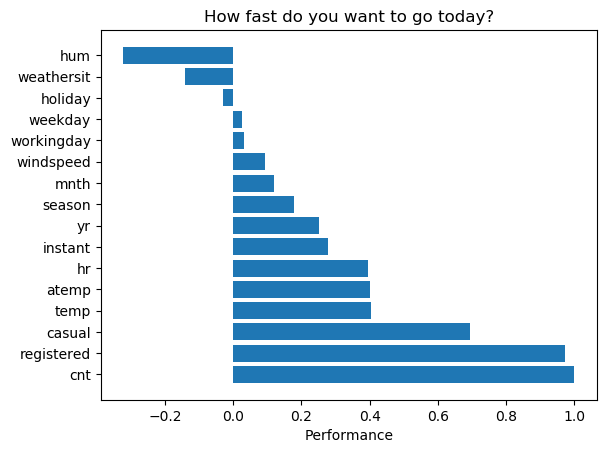

In [216]:
hey = hourly_raw_data.corr()['cnt'][:]
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = hey.sort_values().index
y_pos = np.arange(len(people))
performance = hey.sort_values()

ax.barh(y_pos, performance,  align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('correlation factor')
ax.set_title('Correlation of the variables with the target')

plt.show()

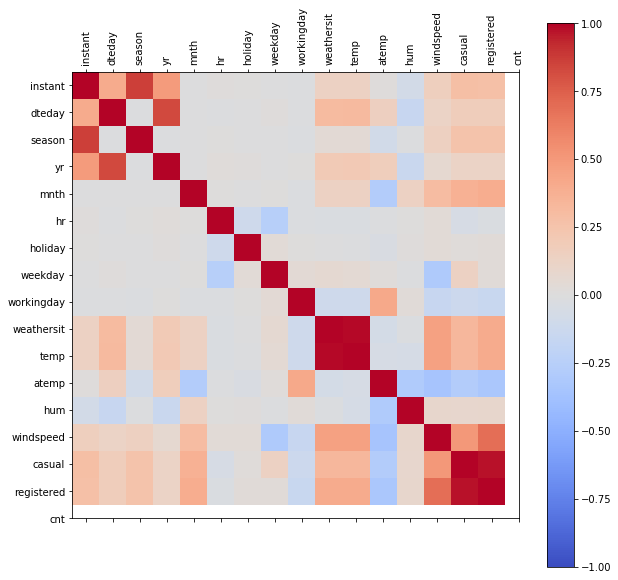

In [16]:
#Hourly
plt.rcParams["figure.figsize"] = (10,10)
corr = hourly_raw_data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(hourly_raw_data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(hourly_raw_data.columns)
ax.set_yticklabels(hourly_raw_data.columns)
plt.show()

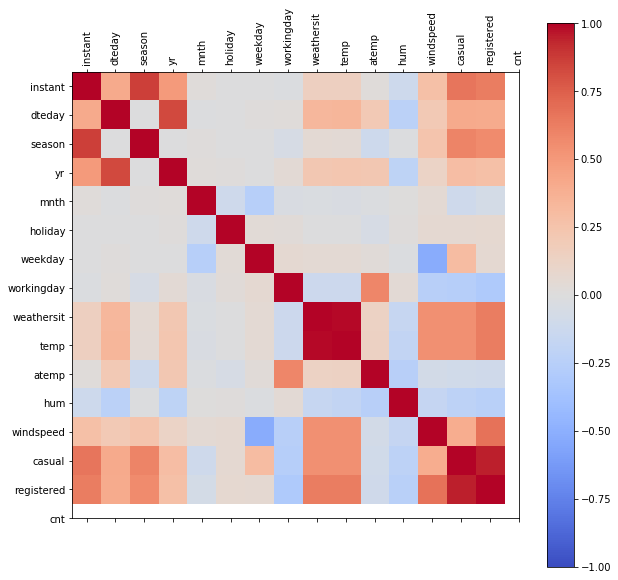

In [15]:
#Daily
plt.rcParams["figure.figsize"] = (10,10)
corr = daily_raw_data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(daily_raw_data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(daily_raw_data.columns)
ax.set_yticklabels(daily_raw_data.columns)
plt.show()

# Data transformation

### Converting `dteday` to date

In [6]:
daily_raw_data['dteday']=pd.to_datetime(daily_raw_data['dteday'], format='%Y-%m-%d')
hourly_raw_data['dteday']=pd.to_datetime(hourly_raw_data['dteday'], format='%Y-%m-%d')
hourly_raw_data['dteday'].head()

0   2011-01-01
1   2011-01-01
2   2011-01-01
3   2011-01-01
4   2011-01-01
Name: dteday, dtype: datetime64[ns]

## Add `isDaylight` and  `isNoon` for hourly data

In [7]:
hourly_raw_data['isDaylight']=0
hourly_raw_data['isNoon']=0

hourly_raw_data = hourly_raw_data.apply(lambda x: isDaylight(x), axis=1)
hourly_raw_data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,isDaylight,isNoon
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,0,0
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,0,0
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,0,0
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,0,0
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,0,0


### Check (and fix?) skewness

In [8]:
check_skewness(hourly_raw_data, ['atemp','temp','hum','windspeed'])

atemp skewness p-value : -0.09042105336080838
temp skewness p-value : -0.00602036366695605
hum skewness p-value : -0.1112775438226877
windspeed skewness p-value : 0.5748555816221624

------

skewed_features:
[]


### Adding the temp atemp windspeed hum relative to the last 7 days value

In [9]:
to_relative  = ['temp', 'atemp', 'hum','windspeed']
hourly_raw_data = relative_values(hourly_raw_data, to_relative)

### Spliting weekends weekdays and arranging the names

In [132]:
wd_hr = num_name(hourly_raw_data.loc[(~hourly_raw_data['weekday'].isin([0,6]) )])
we_hr = num_name(hourly_raw_data.loc[(hourly_raw_data['weekday'].isin([0,6]) )])

### Adding the mean per hour for the past 2 weeks

In [55]:
wd_hr= mean_per_hour_2weeks(wd_hr)
we_hr = mean_per_hour_2weeks(we_hr)

### One hot Encoding
For `season`, `weathersit`, `mnth`,`weekday`,`hr`

In [56]:
category  = ['season', 'weathersit', 'mnth','weekday','hr']

wd_h = onehot_encode(wd_hr,category)
wd_h  = wd_h.drop('instant',axis=1)

we_h = onehot_encode(we_hr,category)
we_h  = we_h.drop('instant',axis=1)

### Genetic Programming

In [57]:
we_h = Genetic_P(we_h.drop(['registered','casual','dteday'],axis=1),'cnt')
wd_h = Genetic_P(wd_h.drop(['registered','casual','dteday'],axis=1),'cnt')

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     8.13 0.11738933907856036        3 0.9040635088192193 0.8779026725412286     25.95s
   1     6.49 0.3861285563373948        3 0.9052611747338453 0.8620950905739327     38.53s
   2     4.44 0.7436519315672128        9 0.9069892000167931 0.8630429158302059     45.33s
   3      2.3 0.8548377965338426        3 0.9085080044124246 0.8447536002622984     46.78s
   4     1.54 0.8811861270270145        1 0.9072835838019927 0.848928471650333     45.03s
   5     1.27 0.8880454399309999        1 0.9078683762887516 0.8455789208838854     42.55s
   6     1.15 0.8943970729977523        1 0.9072386548623287 0.8527776645257942     40.25s
   7     1.09 0.8954390188313005        1 0.9073098857419816 0.8498927674288788     37.51s
   8     1.06 0.89444271476

In [58]:
dd = hourly_raw_data.loc[(~hourly_raw_data['weekday'].isin([0,6]) )]['dteday']
de = hourly_raw_data.loc[(hourly_raw_data['weekday'].isin([0,6]) )]['dteday']
we_h = pd.concat([pd.DataFrame(we_h ),pd.DataFrame(de)],axis=1 ,join = 'inner') 
wd_h = pd.concat([pd.DataFrame(wd_h ),pd.DataFrame(dd)],axis=1 ,join = 'inner') 

In [202]:
we_h

,isNoon,relative_atemp,windspeed,atemp,RushHour-Low,cnt,hum,holiday,workingday,RushHour-High,...,8,9,10,11,12,13,14,dteday,registered,casual
0,0,-0.410671,0.0000,0.2727,1,2,0.80,0,0,0,...,-0.133201,-0.195310,-0.203895,-0.159324,0.170759,-0.122378,-0.048321,2011-01-01,0,2
1,0,-1.697564,0.0000,0.2576,1,3,0.86,0,0,0,...,-0.127460,-0.181013,-0.187575,-0.147935,0.159318,-0.119329,-0.042754,2011-01-01,2,1
2,0,1.049718,0.0000,0.2879,0,8,0.75,0,0,0,...,-0.137870,-0.208580,-0.219541,-0.170073,0.181390,-0.123822,0.184139,2011-01-01,7,1
3,0,5.732372,0.0000,0.3485,0,14,0.76,0,0,0,...,-0.146858,-0.249826,-0.274300,-0.206973,0.215887,-0.113666,0.240283,2011-01-01,6,8
4,0,4.284212,0.2537,0.3939,0,36,0.76,0,0,1,...,0.447671,0.816417,0.491434,0.452388,0.762009,0.948365,0.871304,2011-01-01,24,12
5,0,0.964934,0.2836,0.3333,0,56,0.81,0,0,1,...,0.419169,0.741798,0.450557,0.410423,0.717486,0.889442,0.792965,2011-01-01,30,26
6,1,3.103062,0.2836,0.4242,0,84,0.77,0,0,1,...,0.505376,0.961605,0.565793,0.506898,0.851483,1.067044,1.002804,2011-01-01,55,29
7,0,2.797839,0.2985,0.4545,0,94,0.72,0,0,1,...,0.563550,1.114217,0.644288,0.561458,0.941033,1.185789,1.137611,2011-01-01,47,47
8,0,2.133943,0.2836,0.4545,0,106,0.72,0,0,1,...,0.563550,1.114217,0.644288,0.561458,0.941033,1.185789,1.137611,2011-01-01,71,35
9,0,1.583008,0.2985,0.4394,0,110,0.77,0,0,1,...,0.534442,1.037178,0.604552,0.534219,0.896288,1.126492,1.069952,2011-01-01,70,40


### Correlation Matrix (After hot encoding)

In [ ]:
# Daily
plt.rcParams["figure.figsize"] = (12,8)
corr = daily.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(daily.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(daily.columns)
ax.set_yticklabels(daily.columns)
plt.show()

In [ ]:
#Hourly
plt.rcParams["figure.figsize"] = (12,8)
corr = hourly.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(hourly.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(hourly.columns)
ax.set_yticklabels(hourly.columns)
plt.show()

# Modeling (Baseline)

## Splitting train test

In [200]:
xwe_Train = we_h[we_h['dteday'] < '2012-07-05'].drop(['cnt','dteday','casual','registered'],axis=1)## NONE OF THst_EM IN DATA
xwe_Test = we_h[(we_h['dteday'] >= '2012-07-05' )& (we_h['dteday'] <= '2012-09-30')].drop(['cnt','dteday','casual','registered'],axis=1)## NONE OF THEM IN DATA
ywe_cnt_test =we_h['cnt'][(we_h['dteday'] >= '2012-07-05' )& (we_h['dteday'] <= '2012-09-30')]
ywe_cnt_train =we_h['cnt'][we_h['dteday'] < '2012-07-05']

xwd_Train = wd_h[(wd_h['dteday'] < '2012-07-01') ].drop(['cnt','dteday','casual','registered'],axis=1)## NONE OF THst_EM IN DATA
xwd_Test = wd_h[(wd_h['dteday']  >= '2012-07-01') & (wd_h['dteday'] <= '2012-09-30')].drop(['cnt','dteday','casual','registered'],axis=1)## NONE OF THEM IN DATA
ywd_cnt_test =wd_h['cnt'][(wd_h['dteday'] >= '2012-07-01' )& (wd_h['dteday'] <= '2012-09-30')]
ywd_cnt_train =wd_h['cnt'][wd_h['dteday'] < '2012-07-01']

In [ ]:
# X_Train = hourly[hourly['dteday'] < '2012-10-01'].drop(['cnt','dteday'],axis=1)## NONE OF THst_EM IN DATA
# X_Test = hourly[hourly['dteday'] >= '2012-10-01'].drop(['cnt','dteday'],axis=1)## NONE OF THEM IN DATA
# Y_cnt_test =hourly['cnt'][hourly['dteday'] >= '2012-10-01']
# Y_cnt_train =hourly['cnt'][hourly['dteday'] < '2012-10-01']

isNoon                0.000000
relative_atemp       -0.269198
windspeed             0.089600
atemp                 0.697000
RushHour-Low          1.000000
hum                   0.430000
holiday               1.000000
workingday            0.000000
RushHour-High         0.000000
yr                    1.000000
relative_windspeed   -0.740412
relative_temp        -0.077744
relative_hum         -0.402350
temp                  0.780000
RushHour-Med          0.000000
isDaylight            0.000000
s_fall                0.000000
s_spring              0.000000
s_summer              1.000000
s_winter              0.000000
w_Acceptable          1.000000
w_Bad                 0.000000
w_Chaos               0.000000
w_Good                0.000000
m_1                   0.000000
m_2                   0.000000
m_3                   0.000000
m_4                   0.000000
m_5                   0.000000
m_6                   0.000000
                        ...   
h_9                   0.000000
h_10    

In [ ]:
# Create linear regression object
regr = LinearRegression(fit_intercept =True)
regr.fit(X2_Train, y_cas_train)
y_pred = regr.predict(X2_Test)
r2_score(y_cnt_test,y_reg_test + y_pred)
##regr.score(X2_Test, y_cnt_test)

In [ ]:
params = pd.Series(regr.coef_, index=X2_Train.columns)

Linear Models

In [201]:
##Linear Regression
lm_parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True]}
tscv = TimeSeriesSplit(n_splits=5)
lme = GridSearchCV(LinearRegression(),
                                 param_grid=lm_parameters,
                                 cv=tscv,return_train_score=True)

lme.fit(xwe_Train, ywe_cnt_train)
ywe_pred = lme.predict(xwe_Test)
print(r2_score(ywe_cnt_test, ywe_pred))

0.8417984359963183


In [165]:
##Linear Regression
lm_parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True]}
tscv = TimeSeriesSplit(n_splits=5)
lmd = GridSearchCV(LinearRegression(),
                                 param_grid=lm_parameters,
                                 cv=tscv,return_train_score=True)

lmd.fit(xwd_Train, ywd_cnt_train)
ywd_pred = lmd.predict(xwd_Test)
print(r2_score(ywd_cnt_test, ywd_pred))

0.9038078043940448


In [ ]:
polynomial_features=PolynomialFeatures(degree=2)
xwe_Train_poly=polynomial_features.fit_transform(xwe_Train)
xwe_Test_poly=polynomial_features.fit_transform(xwe_Test)

lm_parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True]}
tscv = TimeSeriesSplit(n_splits=5)
lme = GridSearchCV(LinearRegression(),
                                 param_grid=lm_parameters,
                                 cv=tscv,return_train_score=True)

lme.fit(xwe_Train_poly, ywe_cnt_train)
ywe_pred = lme.predict(xwe_Test_poly)
print(r2_score(ywe_cnt_test, ywe_pred))

In [ ]:
##OrthogonalMatchingPursuit
omp_parameters = {'n_nonzero_coefs':[5,10,15],'fit_intercept':[True,False], 'normalize':[True,False]}
tscv = TimeSeriesSplit(n_splits=5)
omp = GridSearchCV(OrthogonalMatchingPursuit(),
                                 param_grid=omp_parameters,
                                 cv=tscv,return_train_score=True)

omp.fit(X_Train, Y_cnt_train)
omp.cv_results_
omp.score(X_Test, Y_cnt_test)

Random Forest Model

In [81]:
tscv = TimeSeriesSplit(n_splits=5)
RF_parameters = {'n_estimators': [10, 30 ,100],
                                             'bootstrap': [True],
                                             'max_depth': [80, 100 ,150 ],
                                             'max_features': ['sqrt',16 , 32],
                                             'min_samples_leaf': [2,  5 , 8],
                                             'min_samples_split': [ 10 , 8 , 15],
                                            'random_state':[random_seed],
                                            'criterion':['mse']}
rfe = GridSearchCV(RandomForestRegressor(),
                                 param_grid= RF_parameters,
                                 cv=tscv)
rfe.fit(xwe_Train, ywe_cnt_train)
ywe_pred = rfe.predict(xwe_Test)
print(r2_score(ywe_cnt_test, ywe_pred))

0.8606858646909712


In [88]:
r2_score(np.concatenate(ywe_cnt_test,ywd_cnt_test),np.concatenate((ywe_pred ,ywd_pred)) )

TypeError: 'Series' object cannot be interpreted as an integer

In [74]:
tscv = TimeSeriesSplit(n_splits=5)
RF_parameters = {'n_estimators': [10, 30 ,100],
                                             'bootstrap': [True],
                                             'max_depth': [80, 100  ,150],
                                             'max_features': ['sqrt',16,32],
                                             'min_samples_leaf': [2,  5 , 8],
                                             'min_samples_split': [ 10 , 8 , 15],
                                            'random_state':[random_seed],
                                            'criterion':['mse']}
rfd = GridSearchCV(RandomForestRegressor(),
                                 param_grid= RF_parameters,
                                 cv=tscv)
rfd.fit(xwd_Train, ywd_cnt_train)

0.7655003176347412


In [75]:
ywd_pred = rfd.predict(xwd_Test)
print(r2_score(ywd_cnt_test, ywd_pred))

0.8263872865849389


K- Nearest Neighbors

In [70]:
knn_parameters = {'n_neighbors':[5,10,15],'weights':['uniform'], 'algorithm':['auto'],'leaf_size':[20,30],
                  'p':[1,2,3],'metric':['minkowski']}
tscv = TimeSeriesSplit(n_splits=5)
knn = GridSearchCV(KNeighborsRegressor(),
                                 param_grid=knn_parameters,
                                 cv=tscv,return_train_score=True)

knn.fit(xwe_Train, ywe_cnt_train)
ywe_pred = knn.predict(xwe_Test)
print(r2_score(ywe_cnt_test, ywe_pred))

0.7228663539405159


In [69]:
knn_parameters = {'n_neighbors':[5,10,15],'weights':['uniform'], 'algorithm':['auto'],'leaf_size':[20,30],
                  'p':[1,2,3],'metric':['minkowski']}
tscv = TimeSeriesSplit(n_splits=5)
knn = GridSearchCV(KNeighborsRegressor(),
                                 param_grid=knn_parameters,
                                 cv=tscv,return_train_score=True)

knn.fit(xwd_Train, ywd_cnt_train)
ywd_pred = knn.predict(xwd_Test)
print(r2_score(ywd_cnt_test, ywd_pred))

0.7655003176347412


In [91]:
ywd_pred = knn.predict(xwd_Test)
print(r2_score(ywd_cnt_test + ywe_cnt_test, ywd_pred + ywe_pred))

0.7891637696664624


In [159]:

wd_h=pd.read_csv('./workingdays_data_prepared.csv')
we_h=pd.read_csv('./weekends_holi_data_prepared.csv')
wd_h['dteday']=pd.to_datetime(wd_h['dteday'], format='%Y-%m-%d')
we_h['dteday']=pd.to_datetime(we_h['dteday'], format='%Y-%m-%d')